In [4]:
import pyarrow.feather as feather
from concurrent.futures import ThreadPoolExecutor
import pathlib, os, pickle, time, base64, uuid,sys
import numpy as np
from tqdm import tqdm

def load_pickle(thisPickle):
    with open(str(thisPickle), 'rb') as handle:
        batch_features = pickle.load(handle)
    return batch_features.reshape(-1, 4096)

def load_pickle_filesList(thisPickle):
    with open(str(thisPickle), 'rb') as handle:
        batch_elems = pickle.load(handle)
    return batch_elems

Let's first import a set of 600k features, a set of 100k features and our most recent checkpoint - a clustered set of 600,000 images.

In [5]:
pickleFolder = pathlib.Path("faiss-test/600k")
feat_pickles = pickleFolder.rglob('features*.pickle')
list_of_pickles =  [str(p) for p in feat_pickles]

with ThreadPoolExecutor() as executor:
    features_list = list(tqdm(executor.map(load_pickle, list_of_pickles), total=len(list_of_pickles), desc="Loading Pickles"))

print(f"concatenating features")
six_k_features = np.concatenate(features_list, axis=0)


pickleFolder = pathlib.Path("faiss-test/100k")
feat_pickles = pickleFolder.rglob('features*.pickle')
list_of_pickles =  [str(p) for p in feat_pickles]

with ThreadPoolExecutor() as executor:
    features_list = list(tqdm(executor.map(load_pickle, list_of_pickles), total=len(list_of_pickles), desc="Loading Pickles"))

print(f"concatenating features")
one_k_features = np.concatenate(features_list, axis=0)


Loading Pickles: 100%|██████████| 303/303 [00:00<00:00, 332.97it/s]


concatenating features


Loading Pickles: 100%|██████████| 88/88 [00:00<00:00, 359.19it/s]


concatenating features


If we pass this set of features into our clusterer API we get the below graph:

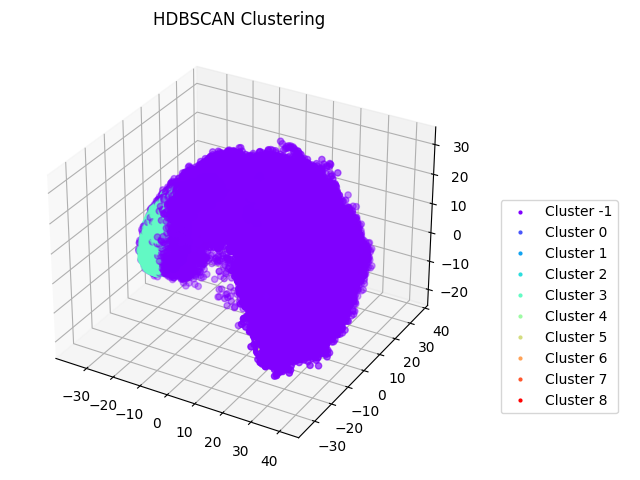

In [5]:
from IPython.display import Image
display(Image(filename='faiss/clustering-example.png'))

Then we'll implement a FAISS database of the first 600,000 and then use this to predict the destination of the additional 100,000 images:

In [6]:
import numpy as np 
import pandas as pd
import faiss , sys

#change the individual rows into numpy arrays of type float32
db_vectors = [np.array(x, dtype="float32") for x in six_k_features ]

#change it from a list of arrays to an array of arrays.
db_vectors = np.array(db_vectors)

dimension = len(db_vectors[0])    # dimensions of each vector                         
n = len(db_vectors)    # number of vectors  

print(dimension,n)

nlist = int(9)  # number of clusters (see above image!)
quantiser = faiss.IndexFlatL2(dimension)  
index = faiss.IndexIVFFlat(quantiser, dimension, nlist,   faiss.METRIC_L2)

index.train(db_vectors)
index.add(db_vectors)

4096 600021


Comparing the two we see that the "correct" group was predicted x% of the time
Getting the groups for all 700,000 took x seconds, while predicting the additional 100,000 groups took y seconds. Of course as the problem scales we may have issues with VRAM or similar, but for now x...